<H1>Authorship in the Federalist Papers</H1>
Use this notebook to replicate the results reporter in the paper  </br>
<ul>
    [1] <a href = https://arxiv.org/abs/1911.01208>
    Kipnis, A., ``Higher Criticism for Discriminating Word-Frequency Tables and Testing Authorship'', 2019
    </a>
</ul>

Use an HC-based test to provide out-of-the-box solution to the case studied in
<ul>
    [2] Mosteller, Frederick, and David L. Wallace. ``<em>Inference in an authorship problem: A comparative study of discrimination methods applied to the authorship of the disputed Federalist Papers</em>''. Journal of the American Statistical Association 58, no. 302 (1963): 275-309.
 </ul>
</br>


In [1]:
import pandas as pd
import numpy as np

#import auxiliary functions for python
import sys
sys.path.append('../AuthAttLib')
from AuthAttLib import *
from visualize_HC_scores import *

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


<H2>Load Data</H2>

In [2]:
print("loading first 77 Federalists Papers:")
from LoadFederalistPapers import load_Federalists_Papers
fed_papers = load_Federalists_Papers(path = "./Federalist_Papers.txt")

loading first 77 Federalists Papers:
Documents loaded:
	 43 Hamilton papers
	 14 Madison papers
	 12 disputed papers


In [3]:
# optional: lemmatize and remove proper names and cardinal numbers
from text_processing import remove_parts_of_speach

fed_papers.loc[:,'text'] = fed_papers.text.apply(
    lambda x : remove_parts_of_speach(x, lemmatize = True,
                                      to_remove = ['NNP', 'NNPS', 'CD']))

In [4]:
# arrange data in the format accepted by AuthAttribLib.AuthorshipAttributionMulti:
# pandas DataFrame with columns 'doc_id', 'author', 'text'
fed_papers.loc[:,'doc_id'] = fed_papers.paper_no

<H2>Train Model</H2>

In [42]:
train_data = fed_papers[fed_papers.author.isin(['Hamilton','Madison'])]

punct = [':',';','"','(',')','-',',','.','`','\`','``','\'\'']

model = AuthorshipAttributionMulti(train_data,
                                   vocab_size = 1550, #use 1500 most frequent words in entire collection
                                   words_to_ignore = punct,
                                  )

	 Creating author-model for Hamilton using 1550 features...
		found 43 documents and 77110 relevant tokens.
	 Creating author-model for Madison using 1550 features...
		found 14 documents and 33808 relevant tokens.


<H3> Asses prdictability using leave-one-out HC scores </H3>

In [43]:
# HC score of each document with respect to the rest in training set
df = model.internal_stats(LOO=False)

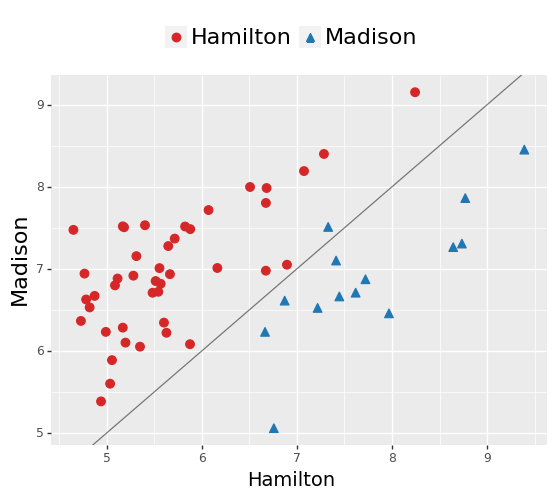

<ggplot: (310669680)>


/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 5 x 3.5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: HC_Hamilton_vs_Madison.png


In [44]:
# illustrate HC scores 
#path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Authorship attribution using Higher Criticism (copy)//Figs/"
path_to_plots = ""

p = (plot_author_pair(df, value = 'HC') + 
     theme(legend_title = element_blank(), legend_position = "top",
              plot_title = element_text(hjust = 0.5, size=16), 
                legend_text=element_text(size=16),
              axis_title_x = element_text(size = 14),
              axis_title_y = element_text(size = 16)) #+ xlim(4,10) + ylim(4,10)
    )

print(p)
p.save(path_to_plots + 'HC_Hamilton_vs_Madison.png', height = 3.5 , width = 5)

<H2>Evaluate Scores of Disputed Papers</H2>

100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


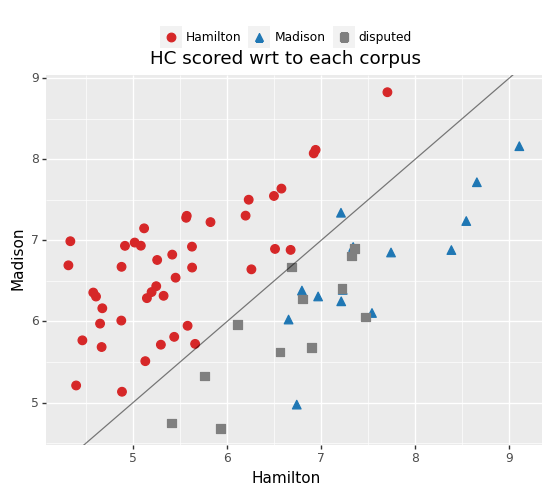

<ggplot: (308112644)>


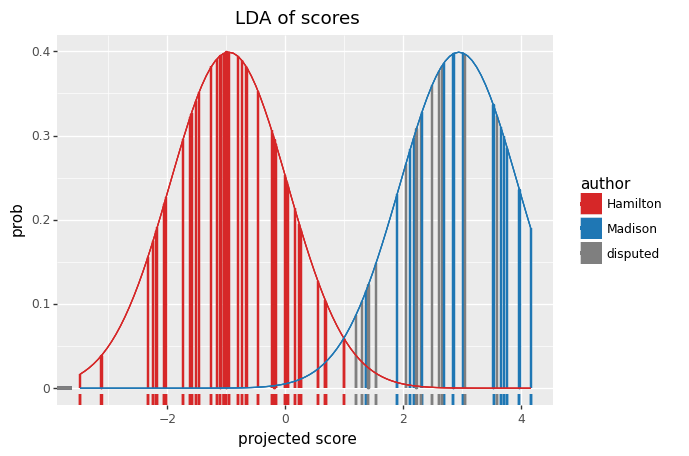

<ggplot: (310469774)>


In [41]:
# Authiorship of disputed papers:
data_disputed = fed_papers[fed_papers.author == 'disputed']

# In order to get the results in [1], set LOO=True 
df_disputed = model.stats_list(data_disputed, LOO = True)  

# illustrate HC scores

df_all = pd.concat([df, df_disputed], sort = True)

p = plot_author_pair(df_all, value = 'HC', wrt_authors=['Hamilton','Madison'])
print(p + ggtitle("HC scored wrt to each corpus"))

p = plot_LDA(df_all, value = 'HC',
             wrt_authors=['Hamilton','Madison']
            )
print(p + ggtitle("LDA of scores"))


<H2>P-values in rank-based test</H2>

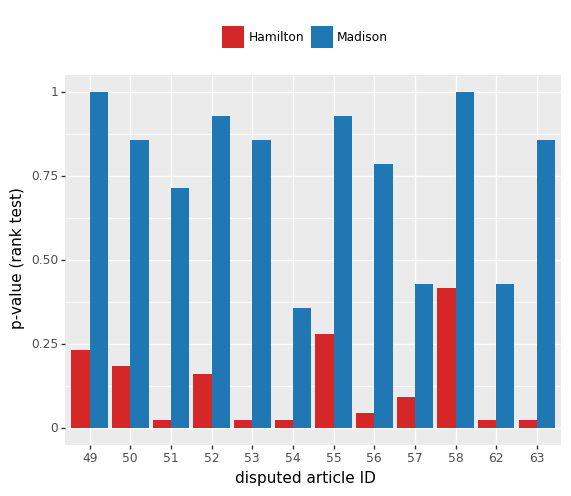

<ggplot: (308349943)>


In [9]:
# P-values in rank-based test:
df_all.loc[:,'pval'] = 1-df_all.loc[:,'HC_rank']

p = plot_author_pair_col(df_all, value = 'pval', wrt_authors = ('Hamilton', 'Madison'), test_author='disputed') +\
theme(legend_title=element_blank(), legend_position='top') + ylab('p-value (rank test)') + xlab('disputed article ID')
print(p)


<H2>Discriminiating Words</H2>

/usr/local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead


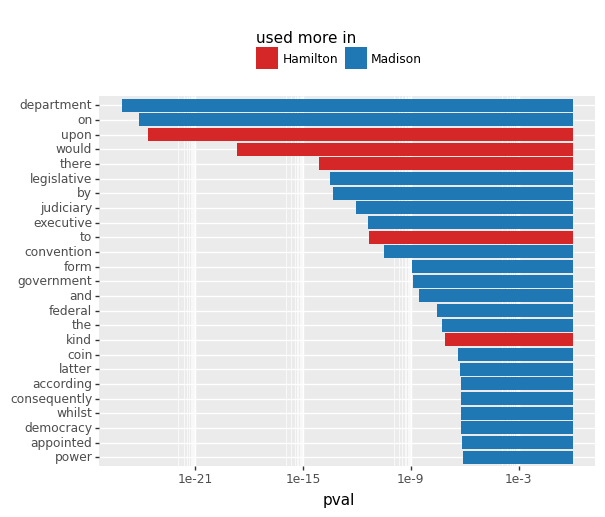

<ggplot: (308349428)>


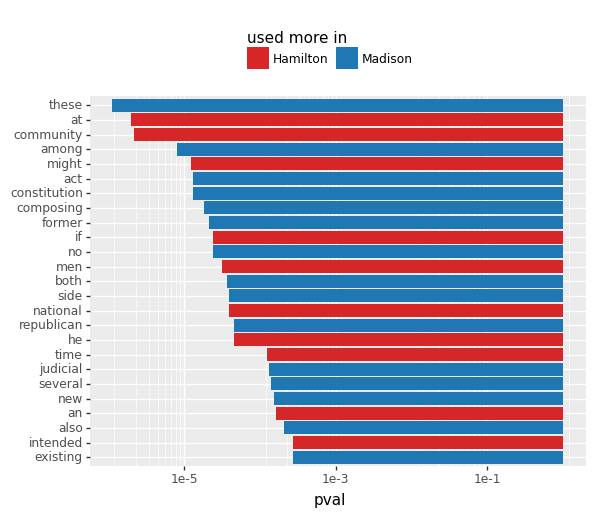

<ggplot: (308364198)>


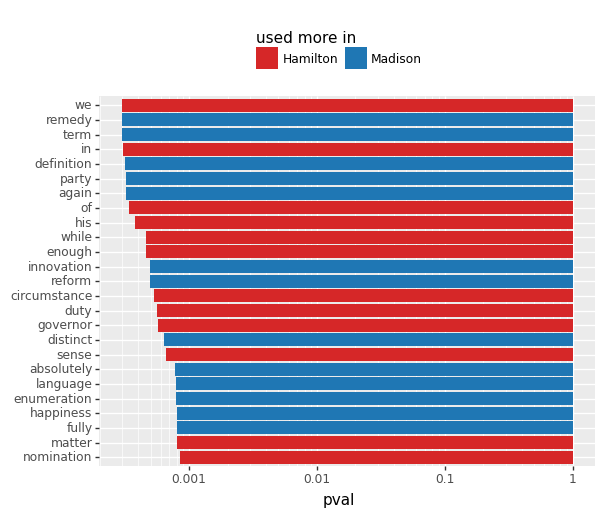

<ggplot: (308351690)>


In [11]:
# word discriminating between the two corpora:
df1 = model.two_author_test('Hamilton','Madison')
df1 =df1.sort_values('pval')

df_discriminating = df1[~np.isnan(df1.sign)]


for i in [0,1,2] :
    k = 25
    p = plot_col(df_discriminating.rename(columns={'feat' : 'term'})[i*k:k*(i+1)],
                 value='pval',sign='sign',wrt_authors=('Hamilton','Madison'))
    print(p)

<H1> Using ``non-contextual'' words from [1]</H1>

In [14]:
MW_final = ["upon", "also" ,"an", "by" , "of", "on", "there", "this", "to", "although", "both", "enough", 
    "while", "whilst", "always", "though", "commonly", "consequently", "considerable",
    "according", "apt", "direction", "innovation", "language", "vigor", "kind",
    "matter", "particularly", "probability", "work"]

function_words =  ['a','as','do','has','is','no','or','than','this','when',
  'all','at','down','have','it','not','our','that','to','which',
  'also','be','even','her','its','now','shall','the','up','who',
  'an','been','every','his','may','of','should','their','upon','will',
  'and','but','for','if','more','on','so','then','was','with',
  'any','by','from','in','must','one','some','there','were','would',
  'are','can','had','into','my','only','such','thing','what','your']

# two list of additional words used by Mosteller & Wallace
additional_words1 = ['affect','city','direction','innovation','perhaps','vigor',
                    'again','commonly','disgracing','join','rapid','violate','although',
                    'consequently','either','language','sarne','violence','among','considerable',
                    'enough','most','second','voice','another','contribute','nor','still',
                    'where','because','defensive','fortune','offensive','those','whether',
                    'between','destruction','function','often','throughout', 'while','both',
                    'did','himself','pass','under','whilst']

additional_words2 = ['about','choice','proper','according','common','kind','propriety','adversaries',
                    'danger','large','provision','after','decide','decides','decided','deciding',
                    'likely','requiisite','aid','degree','matters','matter','substance','always',
                    'during','moreover','they','apt','expence','expences','necessary','though',
                    'asserted','expenses','expense','necessity','necessities','truth','truths',
                    'before','extent','others','us','being','follows','follow','particularly',
                    'usages','usage','better','I','principle','we','care','imagine','edit','editing',
                    'probability','work']

MW_vocab = function_words + additional_words1 + additional_words2


from text_processing import remove_parts_of_speach

def lemmatize_vocab(list_of_words) :
    return remove_parts_of_speach(" ".join(list_of_words), to_remove=[]).split()

# use 176 words considered in [1] :
vocab = lemmatize_vocab(MW_final)

In [15]:
train_data = fed_papers[fed_papers.author.isin(['Hamilton','Madison'])]
model_NC = AuthorshipAttributionMulti(train_data, 
                                      vocab = MW_vocab
                                     )

	 Creating author-model for Hamilton using 176 features...
		found 43 documents and 48725 relevant tokens.
	 Creating author-model for Madison using 176 features...
		found 14 documents and 20898 relevant tokens.


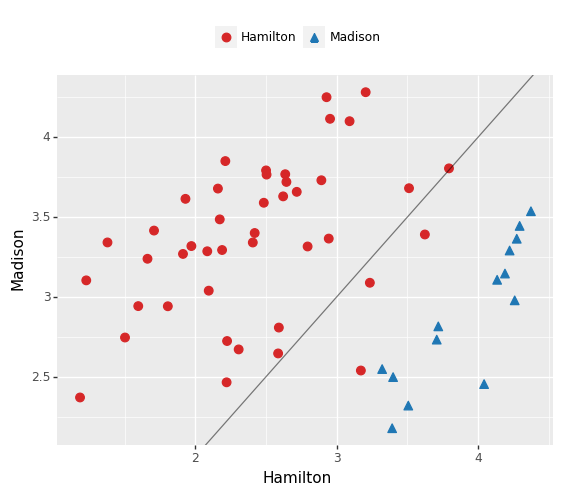

<ggplot: (309522264)>


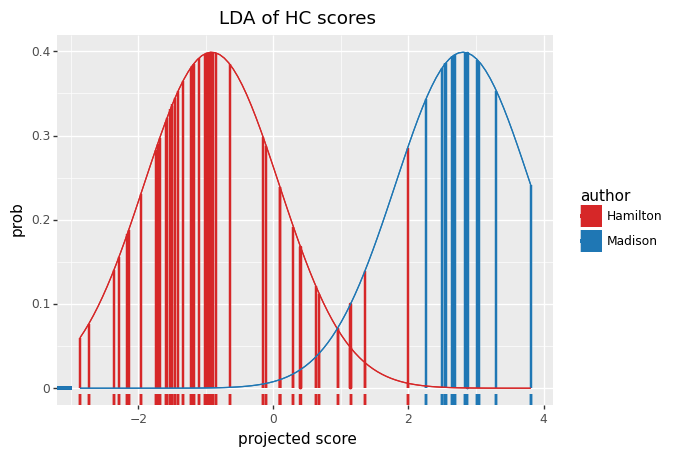

<ggplot: (309522420)>


In [16]:
# HC score of each document with respect to the rest in training set
df_NC = model_NC.internal_stats()

# illustrate HC scores 
p = plot_author_pair(df_NC, value = 'HC')
print(p)

p = plot_LDA(df_NC, value = 'HC', wrt_authors=('Hamilton','Madison'))
print( p + ggtitle('LDA of HC scores'))

100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


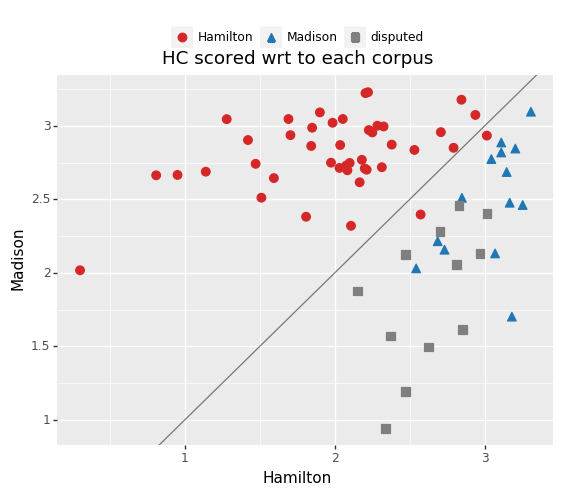

<ggplot: (306204485)>


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


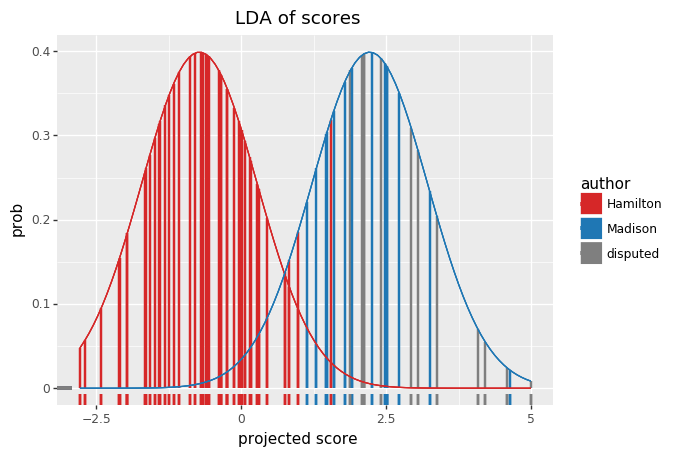

<ggplot: (306186617)>


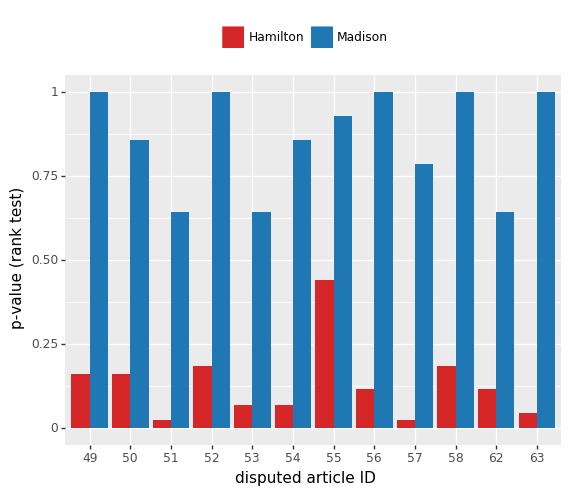

<ggplot: (306755665)>


In [21]:
# Authiorship of disputed papers:
data_disputed = fed_papers[fed_papers.author == 'disputed']

# In order to get the results in [1], set LOO=True 
df_NC_disputed = model_NC.stats_list(data_disputed, LOO = False)  

# illustrate HC scores

df_NC_all = pd.concat([df_NC, df_NC_disputed], sort = False)

p = plot_author_pair(df_NC_all, value = 'HC', wrt_authors=['Hamilton','Madison'])
print(p + ggtitle("HC scored wrt to each corpus"))

p = plot_LDA(df_NC_all, value = 'HC',
             wrt_authors=['Hamilton','Madison']
            )
print(p + ggtitle("LDA of scores"))


# P-values in rank-based test:
df_NC_all.loc[:,'pval'] = 1-df_NC_all.loc[:,'HC_rank']

p = plot_author_pair_col(df_NC_all, value = 'pval', wrt_authors = ('Hamilton', 'Madison'), test_author='disputed') +\
theme(legend_title=element_blank(), legend_position='top') + ylab('p-value (rank test)') + xlab('disputed article ID')
print(p)


/usr/local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead


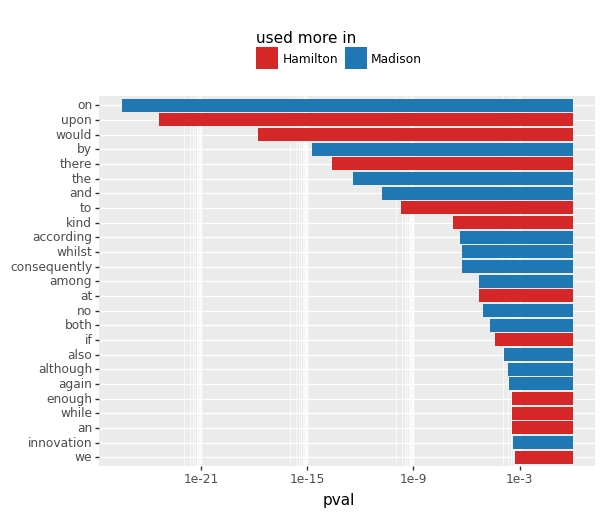

<ggplot: (309565742)>


In [17]:
# word discriminating between the two corpora:
df1 = model_NC.two_author_test('Hamilton','Madison')
df1 = df1.sort_values('pval')

df_discriminating = df1[df1.thresh]

n = len(df_discriminating)

for i in range(int(n/k+0.5)) :
    k = 25
    p = plot_col(df_discriminating.rename(columns={'feat' : 'term'})[i*k:k*(i+1)],
                 value='pval',sign='sign',wrt_authors=('Hamilton','Madison'))
    print(p)

In [18]:
n

34